In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import gym
from collections import deque
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy import cos, sin
from gym import spaces
from gym.error import DependencyNotInstalled
from typing import Optional
from control.matlab import ss, lsim, linspace, c2d
from functools import partial
# from state_estimation import Estimator
import math
import gym
from stable_baselines3 import PPO, SAC, TD3, DDPG, DQN, A2C
from stable_baselines3.common.env_checker import check_env
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
# define CSTR model
def bicycle(x,t,u, params={}):
    lr = 1.105
    lf = 1.738
    psi = x[2]
    v = x[3]
    alpha = u[0]
    sigma = u[1]
    xdot =np.zeros(4)
    beta = math.atan((lr/(lr+lf)*math.tan(sigma)))
    xdot[0] = v*math.cos(psi+beta)
    xdot[1] = v*math.sin(psi+beta)
    xdot[2] = v/lr*math.sin(beta)
    xdot[3] = alpha
    return xdot

In [41]:
class bicycleEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(bicycleEnv).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        ob_high = np.ones(4)*20
        action_high = np.ones(2)*7
        self.action_space = spaces.Box(low=-action_high, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-ob_high, high=ob_high, dtype=np.float32)
        self.step_const = 50
        self.freq = 0.1
        self.steps = 0
        self.center = [2,2,0,2 * math.sqrt(2)]
        # self.obstacle =  np.array(([0.5,0.5,0,math.sqrt(2)/2], [1,1,0,math.sqrt(2)/2]))
        self.obstacle =  np.array(([-0.88615284, -1.00078591, -1.5150387, 2.41190424], [-1.06931684,  0.66430412, -2.53652435,4.46120764]))
        self.reward_cache = [] # cache distances to target norm ball center
        self.final_reward_cache = [] # cache final reward
        self.state = np.random.rand(4)*2-1.2
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.target_norm_radius = 0.6
        self.safe_norm_radius = 0.6
        self.max_reward_list = []
        self.avoid_reward_cache = [] 
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.k = 30
    def step(self, action):
        terminated = False
        ts = [self.horizon[self.steps], self.horizon[self.steps+1] ]
        self.state = odeint(bicycle, self.state, ts, args=(action,))[-1]
        dist = np.linalg.norm(self.state - self.center)
        obs_dist = min( np.linalg.norm(self.state - self.obstacle[0]), np.linalg.norm(self.state - self.obstacle[1]))
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist - self.safe_norm_radius
        # reward = self.target_norm_radius - dist + obs_dist - 0.3
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])    
        final_reward = min(reach_reward, avoid_reward)
        self.reward_cache.append(reward)
        self.steps += 1
        self.total_steps +=1
        # quantitative semantics
        # reach reward, encourage reaching target
        # if self.steps < 10:
        #     reach_reward = max(self.reward_cache)
        # else:
        #     reach_reward = max(self.reward_cache[-10:])
        # final_reward = reach_reward
        if dist <= self.target_norm_radius:
            final_reward = 100
        self.final_reward_cache.append(final_reward)
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            final_reward = -10
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            # self.reset()

        # Return next state, reward, done, info
        return self.state, final_reward, terminated, {}

    def reset(self):
        self.steps = 0
        # self.state = np.random.rand(4)*2-1
        self.state = np.random.rand(4)*2-2.2
        self.reward_cache = []
        self.step_const = self.k
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.final_reward_cache = []
        return self.state  # reward, done, info can't be included

    def render(self, mode="human"):
        return

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [36]:
# Training
reached = []
for k in [20]:
    env = bicycleEnv()
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    # model = SAC("MlpPolicy", env, verbose=0)
    model = SAC.load("SAC_bicycle.zip", env=env)
    model.learn(total_timesteps=100000, progress_bar=False)
    vec_env = model.get_env()
    obs = vec_env.reset()
    env = bicycleEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    dims3 = []
    euclids = []
    # center = [1,1,0,math.sqrt(2)]
    # obstacle = [0.5,0.5,0,math.sqrt(2)/2]
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        dim3 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(2 * env.step_const):
            action, _states = model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dim3.append(state[3])
            dist = np.linalg.norm(new_state-env.center)
            obs_dist = min( np.linalg.norm(env.state - env.obstacle[0]), np.linalg.norm(env.state - env.obstacle[1]))
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        dims3.append(dim3)
        euclids.append(euclid)
    reached.append(num_reached)

Start training with PPO ...


In [37]:
print(num_reached)

840


In [38]:
model.save("SAC_bicycle.zip")

In [22]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint, root
def fgsm_attack(state, model, epsilon, policy, norm, args):
    state = torch.from_numpy(state)
    state = state.detach().unsqueeze(0).requires_grad_(True)
    action = model.actor(state)
    # target = torch.argmax(q_vals).unsqueeze(0)
    # preds = torch.softmax(q_vals, 1)
    # The loss is calcualted with cross entropy
    # current_q = self.critic(state, action)
    # cri = model.critic(state)
    q_vals = (model.critic(state, action))
    loss = (q_vals[0] + q_vals[1]) / 2 * (-1)
    # print(target)
    # loss_func = torch.nn.CrossEntropyLoss()
    # loss = loss_func(preds, target)
    model.actor.zero_grad()
    
    loss.backward()
   
    state_grad = state.grad.detach().squeeze()
    
    state = state.squeeze()
    # Perturb only agent position and ball position
    if norm == float('inf'):
        perturbed_state = state + epsilon * state_grad.sign()
    elif norm == 2:
        perturbed_state = state + epsilon * state_grad / torch.norm(state_grad, norm)
    elif norm == 1:
        index = torch.argmax(state_grad)
        per = torch.zeros_like(state_grad)
        per[index] = 1
        perturbed_state = state + epsilon * per
    return perturbed_state.detach().cpu().numpy()

def white_attack(env, state, model, surro_model, adv_model, epsilon):
    action = model.predict(state, deterministic=True)[0]
    # print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    state_range =  np.array([epsilon])

    def fun(x):
        return min(np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle[0]),np.linalg.norm(odeint(bicycle, state, ts, args=(x,))[-1] - env.obstacle[1]) )
    
    x_start = np.array(action)
    lim = [-7, 7]

    bounds = Bounds([lim[0], lim[0]], [lim[1], lim[1]])  

    ts = [env.horizon[env.steps], env.horizon[env.steps+1] ]
    x_state = odeint(bicycle, state, ts, args=(action,))[-1]

    result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
    # print(result.x)
    op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)
    
    effect = 1000
    for i in range(40):

        action = model.policy._predict(state, deterministic=True)[0].requires_grad_(True)
        action = action * 7
        action = action.double()
#         mse = nn.MSELoss()
        
        # compute the distance
        loss = (torch.tensor([op_action]) - action).pow(2).sum().sqrt()
        # print(loss)
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        model.actor.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
        state_grad = state.grad.detach().squeeze()
        perturbed_state = state - state_grad.sign() * epsilon * 0.1
        l =  torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) +  torch.from_numpy(state_range)
        perturbed_state = torch.max(torch.min(perturbed_state, u), l)
            
        dist = np.linalg.norm(_state - env.center)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)

        if pertub_dist <= dist:
            # 
            if loss <= effect:
                effect = loss
                # print(effect)
                attack = (state.detach().numpy()  - _state)[0]
        state = perturbed_state.detach().requires_grad_(True)
  
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print('find solution')
        return attack
        



In [222]:
# Test 50 traces for safe attack

# norm = 2
norm = float('inf')
res_list = []
epsilon = 0.5
policy = None
args = None
env = bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
clean_env = bicycleEnv()
state = env.reset()
dims0 = []
dims1 = []
dims2 = []
euclids = []
obs_dists = []
obs_dists_list = []
dist_list = []
center = [1,1,0,math.sqrt(2)]
obstacle = env.obstacle
num_reached = 0
action_list = []
pertub_action_list = [] 
number_violate = 0
clean_obs_dists = []
clean_obs_dists_list = []
clean_num_reached = 0
clean_number_violate = 0
clean_obs_dist_list = []
clean_dist_list = []
for epsilon in [ 0.2, 0.5, 0.7]:
    num_reached = 0
    number_violate = 0

    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        euclid = []
        state = env.reset()
        _ = clean_env.reset()
        clean_env.state = state
        clean_state = state
        # print(f'state:{state}')
        # Print initial state
        for i in range(env.step_const):
          
            # print(state)
            attack = safe_attack(env, state, model, epsilon)
            # print(attack)
            pertub_state = state + attack
            # pertub_state = state
            pertub_action = model.predict(pertub_state, deterministic=True)[0]
            # print(pertub_action)
            new_state, reward, done, _ = env.step(pertub_action)
            state = new_state
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                # print('vio')
                env.reset()
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                # print('reach')
                env.reset()
                break
        # print('+++++++++++')   
        # print(obs_dists)
        # print('++++++++++++++++')
        obs_dists_list.append(obs_dists)
        obs_dists = []
        
       
    print(f'epsion:{epsilon}')
    print("Total number reached = " + str(num_reached))
    print("Total number violate = " + str(number_violate))
    print("+++++++++++++++++++++++++++++++++++")
# print("average of obs dist= " + str(sum(obs_dist_list) / len(obs_dist_list)))
res_list.append(num_reached)
# print("clean env for reference")
# print("Total number reached = " + str(clean_num_reached))
# print("Total number violate = " + str(clean_number_violate))
# print("average of obs dist= " + str(sum(clean_obs_dist_list) / len(clean_obs_dist_list)))

epsion:0.2
Total number reached = 681
Total number violate = 247
+++++++++++++++++++++++++++++++++++
epsion:0.5
Total number reached = 370
Total number violate = 228
+++++++++++++++++++++++++++++++++++


KeyboardInterrupt: 

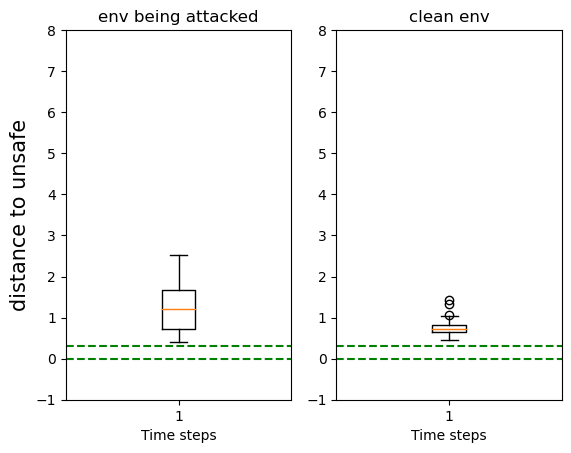

In [49]:
# print((obs_dists_list[0]))

plt.subplot(1, 2, 1)
ave_dist = []
for i in range(50):
#     ave_dist.append(sum(obs_dists_list[i]) / len(obs_dists_list[i]))
    ave_dist.append(min(obs_dists_list[i]))
    # print(obs_dists_list[i])
    # plt.plot(np.arange(len(obs_dists_list[i])), obs_dists_list[i], color='red')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))   
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
plt.ylabel('distance to unsafe', fontsize = 15)
plt.title('env being attacked')
# plt.show()


plt.subplot(1, 2, 2)
ave_dist = []
for i in range(50):
#     ave_dist.append(sum(clean_obs_dists_list[i]) / len(clean_obs_dists_list[i]))
    ave_dist.append(min(clean_obs_dists_list[i]))
    # plt.plot(np.arange(len(clean_obs_dists_list[i])), clean_obs_dists_list[i], color='green')
# print(ave_dist)
plt.boxplot(ave_dist)    
plt.ylim((-1, 8))       
plt.axhline(y=0.3, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot()
plt.xlabel('Time steps')
# plt.ylabel('obstacle distance')
plt.title('clean env')
plt.show()

In [258]:
#  train surrogate policy
reached = []
env = bicycleEnv()
surro_model = SAC.load('surro_SAC_bicycle.zip', env=env)
for k in [30]:
    
    env.k = k
    print('Start training with PPO ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    # surro_model = SAC("MlpPolicy", env, verbose=0)
    surro_model.learn(total_timesteps=100000, progress_bar=False)
    vec_env = surro_model.get_env()
    obs = vec_env.reset()
    env = bicycleEnv()
    env.k = 160
    state = env.reset()
    dims0 = []
    dims1 = []
    dims2 = []
    dims3 = []
    euclids = []
    center = env.center
    obstacle = env.obstacle
    num_reached = 0
    for j in range(1000):
        dim0 = []
        dim1 = []
        dim2 = []
        dim3 = []
        euclid = []
        state = env.reset()
        # Print initial state
        for i in range(50):
            action, _states = surro_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
            dim0.append(state[0])
            dim1.append(state[1])
            dim2.append(state[2])
            dim3.append(state[3])
            dist = np.linalg.norm(new_state-center)
            obs_dist = min(np.linalg.norm(new_state - env.obstacle[0]), np.linalg.norm(new_state - env.obstacle[1]))
            euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
        dims0.append(dim0)
        dims1.append(dim1)
        dims2.append(dim2)
        dims3.append(dim3)
        euclids.append(euclid)
    reached.append(num_reached)


Start training with PPO ...


In [259]:
surro_model.save('surro_SAC_bicycle.zip')
print(reached)

[747]


Total number reached = 14
Total number violate = 1
clean env for reference
Total number reached = 89
Total number violate = 0


In [27]:
class adv_bicycleEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(bicycleEnv).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        ob_high = np.ones(4)*20
        action_high = np.ones(2)*7
        self.action_space = spaces.Box(low=-action_high, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-ob_high, high=ob_high, dtype=np.float32)
        self.step_const = 50
        self.freq = 0.1
        self.steps = 0
        self.center = [1,1,0,math.sqrt(2)]
        self.obstacle =  np.array(([-0.88615284, -1.00078591, -1.5150387, 2.41190424], [-1.06931684,  0.66430412, -2.53652435,4.46120764]))
        self.reward_cache = [] # cache distances to target norm ball center
        self.final_reward_cache = [] # cache final reward
        self.state = np.random.rand(4)*2-1
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.target_norm_radius = 0.8
        self.safe_norm_radius = 0.4
        self.max_reward_list = []
        self.avoid_reward_cache = [] 
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.k = 20
    def step(self, action):
        terminated = False
        ts = [self.horizon[self.steps], self.horizon[self.steps+1] ]
        self.state = odeint(bicycle, self.state, ts, args=(action,))[-1]
        dist = np.linalg.norm(self.state - self.center)
        obs_dist = np.linalg.norm(self.state - self.obstacle)
#         reward = self.target_norm_radius - dist
        obs_reward = obs_dist - self.safe_norm_radius
        obs_reward = -obs_reward
        # reward = self.target_norm_radius - dist + obs_dist - 0.3
#         self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
#         if self.steps < 10:
#             reach_reward = max(self.reward_cache)
#         else:
#             reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])    
#         final_reward = min(reach_reward, avoid_reward)
        final_reward =  avoid_reward
        self.reward_cache.append(reward)
        self.steps += 1
        self.total_steps +=1
        # quantitative semantics
        # reach reward, encourage reaching target
        # if self.steps < 10:
        #     reach_reward = max(self.reward_cache)
        # else:
        #     reach_reward = max(self.reward_cache[-10:])
        # final_reward = reach_reward
        # if dist <= self.target_norm_radius:
        #     final_reward = 10
        self.final_reward_cache.append(final_reward)
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            # self.reset()

        # Return next state, reward, done, info
        return self.state, final_reward, terminated, {}

    def reset(self):
        self.steps = 0
        # self.state = np.random.rand(4)*2-1
        self.state = np.random.rand(4)*2-1.2
        self.reward_cache = []
        self.step_const = self.k
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.final_reward_cache = []
        return self.state  # reward, done, info can't be included

    def render(self, mode="human"):
        return

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [250]:
#  train adv policy
reached = []
env = adv_bicycleEnv()
adv_model = SAC.load('adv_SAC_bicycle.zip', env=env)
for k in [30]:
    
    env.k = k
    print('Start training with SAC ...')
    # learning_rate = 1e-3, n_steps = 1024, tune these
    # adv_model = SAC("MlpPolicy", env, verbose=0)
    adv_model.learn(total_timesteps=300000, progress_bar=False)
    vec_env = adv_model.get_env()
    obs = vec_env.reset()
#     env = adv_bicycleEnv()
    env.k = 160
    state = env.reset()
#     dims0 = []
#     dims1 = []
#     dims2 = []
#     dims3 = []
#     euclids = []
    center = env.center
    obstacle = env.obstacle
    num_reached = 0
    for j in range(1000):
#         dim0 = []
#         dim1 = []
#         dim2 = []
#         dim3 = []
#         euclid = []
        state = env.reset()
        # Print initial state
        for i in range(50):
            action, _states = adv_model.predict(state, deterministic=True)
            new_state, reward, done, _ = env.step(action)
#             dim0.append(state[0])
#             dim1.append(state[1])
#             dim2.append(state[2])
#             dim3.append(state[3])
            dist = np.linalg.norm(new_state-center)
            obs_dist = np.linalg.norm(new_state-obstacle)
#             euclid.append(dist)
            state = new_state
            if obs_dist <= env.safe_norm_radius:
                
                break
#             if dist <= env.target_norm_radius: # stop
#                 num_reached += 1
#                 break
#         dims0.append(dim0)
#         dims1.append(dim1)
#         dims2.append(dim2)
#         dims3.append(dim3)
#         euclids.append(euclid)
    reached.append(num_reached)


Start training with SAC ...


In [251]:
adv_model.save('adv_SAC_bicycle.zip')

In [252]:
print(num_reached)

0


In [29]:

def black_attack(env, state, model, surro_model,adv_model, epsilon):
    action = surro_model.predict(state)[0]
#     print(action)
    effect = None
    attack = None
    _action = action
    _state = state
    state_range =  np.array([epsilon])

    

    op_action = adv_model.predict(state)[0]
#     op_action = (result.x)
    state = torch.from_numpy(state)
    
    state = state.detach().unsqueeze(0).requires_grad_(True)

    effect = 1000

    for i in range(40):
        
        action = surro_model.policy._predict(state, deterministic=True)[0].requires_grad_(True)
        action = action * 7
        action = action.double().requires_grad_(True)
        # print(action)
        # compute the distance
        loss = (torch.tensor([op_action]) - action).pow(2).sum().sqrt()
        
        # loss = mse(torch.tensor([op_action]).requires_grad_(True), action)
        surro_model.policy.zero_grad()
        loss = loss.double()
        # print(action.dtype)
        loss.backward()
        state_grad = state.grad.detach().squeeze()
        # print(state_grad)
        perturbed_state = state - state_grad.sign() * epsilon * 0.1
        l =  torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) +  torch.from_numpy(state_range)
        perturbed_state = torch.max(torch.min(perturbed_state, u), l)
        dist = np.linalg.norm(_state - env.center)
        pertub_dist = np.linalg.norm(state.detach().numpy() - env.center)
        
        if pertub_dist <= dist:
            # 
            if loss <= effect:
                effect = loss
                # print(effect)
                attack = (state.detach().numpy() - _state)[0]
        state = perturbed_state.detach().requires_grad_(True)
        # print(f'state:{perturbed_state}')
        # print(f'action:{_action}, op_action:{op_action}')
 
    if attack is None:
        return np.zeros_like(_state)
    else:
        # print(attack)
        return attack       

In [25]:
def Gradient_attack(env, state, model, surro_model, adv_model, epsilon):
    # print(type(state))
    _action = surro_model.predict(state)[0]
    _state = state
    action = surro_model.predict(state)[0]
    state_range = _state / np.linalg.norm(_state) * epsilon * math.sqrt(44)
    # print(surro_model.policy)
    Q = surro_model.critic_target(torch.from_numpy(_state).view(1,-1), torch.from_numpy(action).view(1,-1))[0]
    attack = None
    for i in range(20):
        state = torch.tensor(state)
        # print(state)
        state.requires_grad_(True)

        Q_cur = surro_model.critic_target(state.view(1,-1), torch.from_numpy(action).view(1, -1))[0]
        # print(Q_cur)
        model.policy.zero_grad()

        Q_cur.backward()
        grad = state.grad
        grad_dir = grad.sign() * epsilon * 0.1

        state = state - grad_dir

        state_range = np.array([epsilon])
        l = torch.from_numpy(_state) - torch.from_numpy(state_range)
        u = torch.from_numpy(_state) + torch.from_numpy(state_range)
        state = torch.max(torch.min(state, u), l)
        action = surro_model.predict(state.detach().numpy())[0]
        Q_adv = surro_model.critic(torch.from_numpy(_state).view(1, -1), torch.from_numpy(action).view(1, -1))[0]
        if Q_adv <= Q:
            Q = Q_adv
            attack = (state.detach().numpy() - _state)
    if attack is not None:
        # print(attack)
        return attack

    else:
        # print("no attack")
        return np.zeros_like(_state)

In [67]:

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 10
policy = None
args = None

def white(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range( env.step_const):
            attack = white_attack(env, state, model, surro_model, adv_model, epsilon)
            
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'white attack violation:{number_violate}, reach:{num_reached}')

def black(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range( env.step_const):
            attack = black_attack(env, state, model, surro_model, adv_model, epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            # pertub_action_list.append(pertub_action[0])
            state = new_state
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'black attack violation:{number_violate}, reach:{num_reached}')

def grey_s(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range( env.step_const):
            attack = white_attack(env, state, model=surro_model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'grey_s attack violation:{number_violate}, reach:{num_reached}')
def MAD(env, obs, model, surro_model, adv_model, epsilon):
        action = model.predict(obs, deterministic=True)[0]
        # print(action)
        effect = None
        attack = None
        _action = action
        _state = obs
        state_range = np.array([epsilon])

        def fun(x):
            u = model.predict(x + _state, deterministic=True)[0]
            result = np.sum(np.power(action - u, 2)) * (-1)
            return result

        x_start = np.zeros_like(_state)
        lim = np.zeros_like(_state) + epsilon

        bounds = Bounds(-lim, lim)

        result = minimize(fun, x_start, method='trust-constr', bounds=bounds)
        # print(result.x)

        op_action = (result.x)
        return op_action
def gradient(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        for i in range(env.step_const):
            attack = Gradient_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'gradient attack violation:{number_violate}, reach:{num_reached}')    
def mad(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    black_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        dist_list = []
        for i in range( 2* env.step_const):
            attack = MAD(env, state, model, surro_model, adv_model, epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            # pertub_action_list.append(pertub_action[0])
            state = new_state
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                black_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                black_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'mad attack violation:{number_violate}, reach:{num_reached}')
    return black_dist_list
def grey_c(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        for i in range(env.step_const):
            attack = black_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'grey_c attack violation:{number_violate}, reach:{num_reached}')
env = bicycleEnv()
adv_env = adv_bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
surro_model = SAC.load('surro_SAC_bicycle.zip', env=env)
adv_model = SAC.load('adv_SAC_bicycle.zip', env=adv_env)
baseline_model = SAC.load('baseline_bicycle_model.zip', env=env)
total_epoch = 250
for epsilon in [ 0.01, 0.05, 0.10, 0.15]:
     print(epsilon)
     black(env, model, surro_model,baseline_model, epsilon, total_epoch)
     # mad(env, model, surro_model,adv_model, epsilon, total_epoch)
     # white(env, model, surro_model,adv_model, epsilon, total_epoch)
     # black(env, model, surro_model,adv_model, epsilon, total_epoch)
     # grey_c(env, model, surro_model,adv_model, epsilon, total_epoch)
     # grey_s(env, model, surro_model,adv_model, epsilon, total_epoch)
     # gradient(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     print('++++++++++')

0.01
black attack violation:34, reach:179
++++++++++
0.05
black attack violation:42, reach:163
++++++++++
0.1
black attack violation:47, reach:168
++++++++++
0.15
black attack violation:44, reach:164
++++++++++


C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


0.15
black attack violation:11, reach:37


C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


white attack violation:3, reach:46
grey_c attack violation:6, reach:44


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grey_s attack violation:8, reach:41
++++++++++


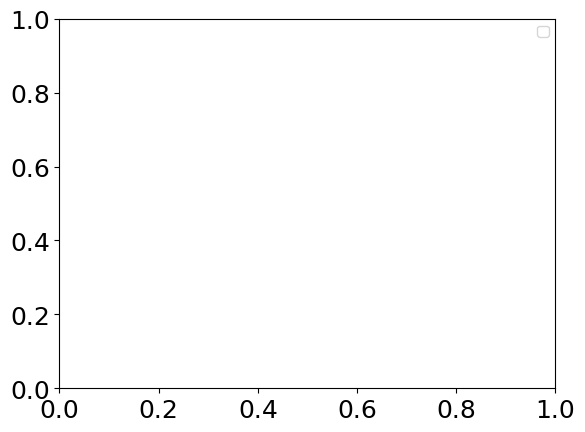

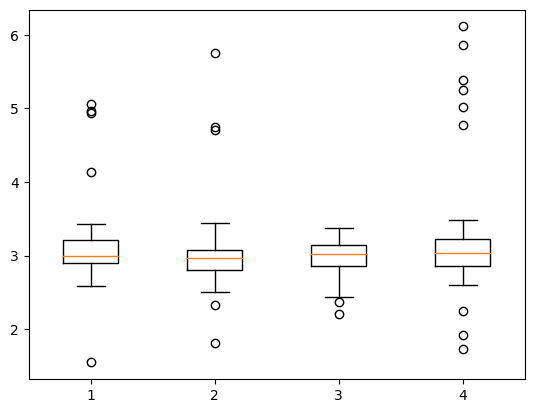

In [47]:
# draw trajactory

# test white, grey, black box attack
norm = float('inf')
res_list = []
epsilon = 10
policy = None
args = None

def white(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    white_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        # clean_state = clean_env.reset()
        for i in range( 2* env.step_const):
            attack = white_attack(env, state, model, surro_model, adv_model, epsilon)
            
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                white_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                white_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'white attack violation:{number_violate}, reach:{num_reached}')
    return white_dist_list

def black(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    black_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        dist_list = []
        for i in range( 2* env.step_const):
            attack = black_attack(env, state, model, surro_model, adv_model, epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            # pertub_action_list.append(pertub_action[0])
            state = new_state
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                black_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                black_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'black attack violation:{number_violate}, reach:{num_reached}')
    return black_dist_list

def grey_s(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_s_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        # clean_state = clean_env.reset()
        dist_list = []
        for i in range( 2 * env.step_const):
            attack = white_attack(env, state, model=surro_model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_s_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_s_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'grey_s attack violation:{number_violate}, reach:{num_reached}')
    return grey_s_dist_list
    
def gradient(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    for j in range(total_epoch):
        state = env.reset()
        for i in range(2 * env.step_const):
            attack = Gradient_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                break
            if done:
                env.reset()
    print(f'GA attack violation:{number_violate}, reach:{num_reached}')
    
def grey_c(env, model, surro_model,adv_model, epsilon, total_epoch=100):
    
    epsilon = epsilon

    num_reached = 0
    number_violate = 0
    grey_c_dist_list = []
    for j in range(total_epoch):
        state = env.reset()
        dist_list = []
        for i in range(2 * env.step_const):
            attack = black_attack(env, state, model=model, surro_model=model, adv_model=adv_model, epsilon=epsilon)
        
            pertub_state = state + attack

            pertub_action = model.predict(pertub_state, deterministic=True)[0]

            new_state, reward, done, _ = env.step(pertub_action)
            
            
            dist = np.linalg.norm(state - env.center)
            obs_dist = min(np.linalg.norm(state - env.obstacle[0]), np.linalg.norm(state - env.obstacle[1]))
            dist_list.append(obs_dist)
            state = new_state
            # pertub_action_list.append(pertub_action[0])
            # action_list.append(action)
            
            # obs_dists.append(obs_dist)
            if obs_dist <= env.safe_norm_radius:
                number_violate += 1
                grey_c_dist_list.append(dist_list)
                break
            if dist <= env.target_norm_radius: # stop
                num_reached += 1
                grey_c_dist_list.append(dist_list)
                break
            if done:
                env.reset()
    print(f'grey_c attack violation:{number_violate}, reach:{num_reached}')
    return grey_c_dist_list
env = bicycleEnv()
adv_env = adv_bicycleEnv()
model = SAC.load("SAC_bicycle.zip", env=env)
surro_model = SAC.load('surro_SAC_bicycle.zip', env=env)
adv_model = SAC.load('adv_SAC_bicycle.zip', env=adv_env)
total_epoch = 50
for epsilon in [0.15]:
     print(epsilon)
     black_dist_list = black(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     white_dist_list = white(env=env, model=model, surro_model=surro_model, adv_model=adv_model,
                                                 epsilon=epsilon, total_epoch=total_epoch)

     grey_c_dist_list = grey_c(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon , total_epoch= total_epoch)
     grey_s_dist_list = grey_s(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     # gradient(env=env,  model=model, surro_model=surro_model, adv_model=adv_model, epsilon=epsilon, total_epoch= total_epoch)
     print('++++++++++')
     
white_ave = []
black_ave = []
grey_c_ave = []
grey_s_ave = []
for i in range(0, len(white_dist_list)):
    white_ave.append(np.sum(white_dist_list[i])/len(white_dist_list[i])  )
for i in range(0, len(black_dist_list)):
    black_ave.append(np.sum(black_dist_list[i])/len(black_dist_list[i])  )
for i in range(0, len(grey_c_dist_list)):
    grey_c_ave.append(np.sum(grey_c_dist_list[i])/len(grey_c_dist_list[i]) )
for i in range(0, len(grey_s_dist_list)):
    grey_s_ave.append(np.sum(grey_s_dist_list[i])/len(grey_s_dist_list[i]) )
# for i in range(0, len(white_dist_list)):
#     white_ave.append(np.min(white_dist_list[i])  )
# for i in range(0, len(black_dist_list)):
#     black_ave.append(np.min(black_dist_list[i]))
# for i in range(0, len(grey_c_dist_list)):
#     grey_c_ave.append(np.min(grey_c_dist_list[i]) )
# for i in range(0, len(grey_s_dist_list)):
#     grey_s_ave.append(np.min(grey_s_dist_list[i]))



plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.legend()
plt.show()
# plt.savefig('dcmotor_stealthy.png', dpi=500)
data = [white_ave, grey_c_ave, grey_s_ave, black_ave]
plt.boxplot(data)
plt.show()


with open(r'bicy_white_dist.txt', 'w') as fp:
    for item in white_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(r'bicy_black_dist.txt', 'w') as fp:
    for item in black_ave:
        # write each item on a new line
        fp.write("%s\n" % item)

with open(r'bicy_grey_c_dist.txt', 'w') as fp:
    for item in grey_c_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(r'bicy_grey_s_dist.txt', 'w') as fp:
    for item in grey_s_ave:
        # write each item on a new line
        fp.write("%s\n" % item)
     

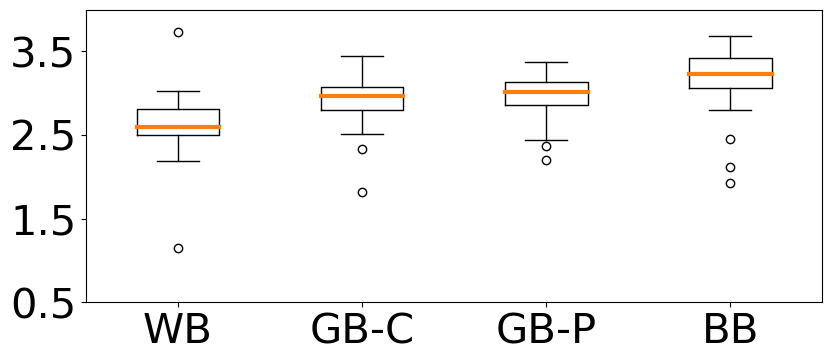

In [59]:
import matplotlib.pyplot as plt
white_ave = []
black_ave = []
grey_c_ave = []
grey_s_ave = []

with open(r'bicy_white_dist.txt', 'r') as fp:
    white_ave = [float(x)-0.4  for x in fp.read().split()]
    # print(white_ave)

with open(r'bicy_black_dist.txt', 'r') as fp:
    black_ave = [float(x)+0.2 for x in fp.read().split()]

with open(r'bicy_grey_c_dist.txt', 'r') as fp:
    grey_c_ave = [float(x) for x in fp.read().split()]

with open(r'bicy_grey_s_dist.txt', 'r') as fp:
    grey_s_ave = [float(x) for x in fp.read().split()]

# fig = plt.figure()
#
# fig.set_figheight(3)
# fig.set_figwidth(9)


import seaborn as sns
fig, ax = plt.subplots()
fig.set_figheight(3.8)
fig.set_figwidth(9.5)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
# plt.show()
# plt.ylabel('Robustness of safety', fontsize=16)
data = [white_ave, grey_c_ave, grey_s_ave, black_ave]
B = ax.boxplot(data, medianprops=dict(linewidth=3), labels=("WB","GB-C","GB-P", 'BB'))
middle = [item.get_ydata()[1] for item in B['medians']]

plt.ylim(0.5, 4)
ax.yaxis.set_ticks(np.arange(0.5, 4, 1))

# plt.legend()
plt.savefig('box_Bicycle.pdf', bbox_inches='tight', dpi=500)

plt.show()




In [52]:
class baseline_bicycleEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render.modes": ["human"]}

    def __init__(self, render_mode: Optional[str] = None, g=10.0):
        super(baseline_bicycleEnv).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        ob_high = np.ones(4)*20
        action_high = np.ones(2)*7
        self.action_space = spaces.Box(low=-action_high, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-ob_high, high=ob_high, dtype=np.float32)
        self.step_const = 50
        self.freq = 0.1
        self.steps = 0
        self.center = [2,2,0,2 * math.sqrt(2)]
        # self.obstacle =  np.array(([0.5,0.5,0,math.sqrt(2)/2], [1,1,0,math.sqrt(2)/2]))
        self.obstacle =  np.array(([-0.88615284, -1.00078591, -1.5150387, 2.41190424], [-1.06931684,  0.66430412, -2.53652435,4.46120764]))
        self.reward_cache = [] # cache distances to target norm ball center
        self.final_reward_cache = [] # cache final reward
        self.state = np.random.rand(4)*2-2.2
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.target_norm_radius = 0.6
        self.safe_norm_radius = 0.4
        self.max_reward_list = []
        self.avoid_reward_cache = [] 
        self.quality_list = []
        self.total_steps = 0
        self.step_history = []
        self.k = 30
    def step(self, action):
        terminated = False
        ts = [self.horizon[self.steps], self.horizon[self.steps+1] ]
        self.state = odeint(bicycle, self.state, ts, args=(action,))[-1]
        dist = np.linalg.norm(self.state - self.center)
        obs_dist = min( np.linalg.norm(self.state - self.obstacle[0]), np.linalg.norm(self.state - self.obstacle[1]))
        reward = self.target_norm_radius - dist
        obs_reward = obs_dist - self.safe_norm_radius
        # reward = self.target_norm_radius - dist + obs_dist - 0.3
        self.reward_cache.append(reward)
        self.avoid_reward_cache.append(obs_reward)
        if self.steps < 10:
            reach_reward = max(self.reward_cache)
        else:
            reach_reward = max(self.reward_cache[-10:])
        if self.steps < 10:
            avoid_reward = min(self.avoid_reward_cache)
        else:
            avoid_reward = min(self.avoid_reward_cache[-10:])    
        final_reward = - reward
        self.reward_cache.append(reward)
        self.steps += 1
        self.total_steps +=1
    
        # if dist <= self.target_norm_radius:
        #     final_reward = 100
        self.final_reward_cache.append(final_reward)
        if self.steps == self.step_const or obs_dist<=self.safe_norm_radius:
            # final_reward = -10
            self.max_reward_list.append(max(self.final_reward_cache)) # use max final reward to measure episodes
            self.step_history.append(self.total_steps)
            self.quality_list.append(sum(self.final_reward_cache))
            terminated = True
            # self.reset()

        # Return next state, reward, done, info
        return self.state, final_reward, terminated, {}

    def reset(self):
        self.steps = 0
        # self.state = np.random.rand(4)*2-1
        self.state = np.random.rand(4)*2-2.2
        self.reward_cache = []
        self.step_const = self.k
        self.horizon = np.arange(0, self.step_const+2, 1)*0.1
        self.final_reward_cache = []
        return self.state  # reward, done, info can't be included

    def render(self, mode="human"):
        return

    def close(self):
        if self.screen is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [60]:
# Training
reached = []
for k in [20]:
    env = baseline_bicycleEnv()
    env.k = k
    print('Start training with PPO ...')
    baseline_model = SAC("MlpPolicy", env, verbose=0)
 
    baseline_model.learn(total_timesteps=500000, progress_bar=False)

baseline_model.save('baseline_bicycle_model.zip')
print(done)

C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\sjiang5\anaconda3\envs\example\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Start training with PPO ...


KeyboardInterrupt: 